# Circuit Breaker - Predictive Maintenance
## Schritt 1: Datensatz generieren

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
n_samples = 1000
t = np.linspace(0, 10, n_samples)  # Zeit von 0 bis 10 Sekunden

# Normalbetrieb: saubere Sinuskurve
normal = np.sin(2 * np.pi * t)

# Fehlerfall: Sinus + Rauschen + Anomalie
noise = np.random.normal(0, 0.3, n_samples)
fault = np.sin(2 * np.pi * t) + noise
fault[500:550] += 3.0  # Anomalie bei t=5s

print('Normalbetrieb shape:', normal.shape)
print('Fehlerfall shape:', fault.shape)

Normalbetrieb shape: (1000,)
Fehlerfall shape: (1000,)


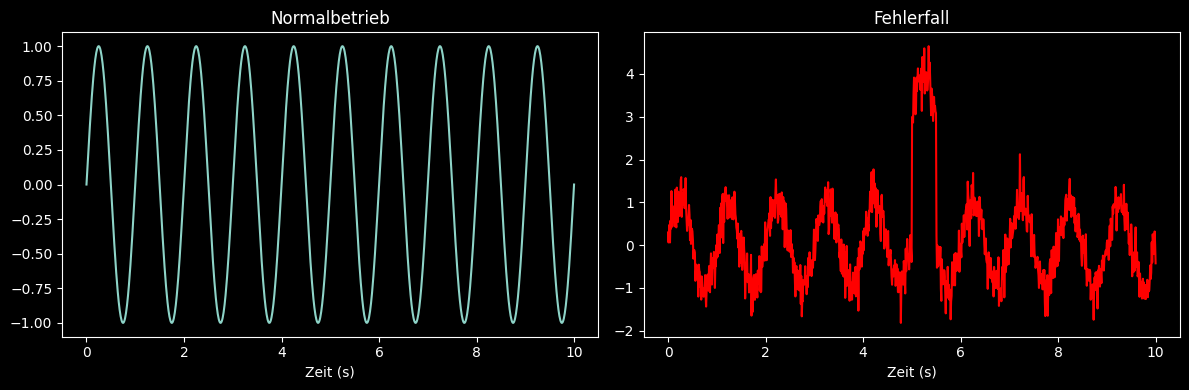

In [5]:
# Plotten
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(t, normal)
plt.title('Normalbetrieb')
plt.xlabel('Zeit (s)')

plt.subplot(1, 2, 2)
plt.plot(t, fault, color='red')
plt.title('Fehlerfall')
plt.xlabel('Zeit (s)')

plt.tight_layout()
plt.show()